## Import statements

In [1]:
import os,sys
import datetime

In [2]:
import scanpy as sc
sc.logging.print_versions()
sc.logging.print_memory_usage()
sc.settings.verbosity = 2

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.7 numpy==1.15.4 scipy==1.3.1 pandas==0.23.4 scikit-learn==0.20.1 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1
Memory usage: current 0.20 GB, difference +0.20 GB


In [3]:
## This cell is run once to download my custom functions and import statements from github
#
#!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions
#    
## github doesn't seem to have an option to download a specific version of the repo from the history.
## So I download my utility functions and save the download time by appending it to the directory name.
## These utility functions to be shared together with the notebook.
#
#toappend = datetime.datetime.now().strftime('%y%m%d_%Hh%M')
#newname = "utility_functions_%s"%toappend
#print(newname)
#
#
## rename the py file with utility functions
#os.rename("utility_functions",newname)

In [4]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("../utility_functions_200517_09h14/"))

from rz_import_statements import *
import rz_functions as rz
import rz_utility_spring as srz

python version: 3.6.7


## Load  scRNAseq data

In [6]:
# load counts
adata = sc.read_h5ad('data/mito_total_counts_filt_raw_27563x40930_200517_10h29.h5ad')

In [7]:
# overwrite obs with the most recent version
adata.obs = rz.load_df('data/obs_info_27563x32_200705_10h46.npz')

# alternatively, if using the tsv version from GEO, use the line below
#adata.obs = pd.read_csv('obs_info_27563x32_201025_14h44.tsv',sep='\t',index_col=0)

## Load xy coordinates

In [10]:
xy = pd.read_csv('data/from_spring_all_Cd45pos_cells/coordinates.txt',header=None,index_col=0)
xy.head()

,1,2
0,,
0,218.384705,-566.210362
1,1347.487578,-666.992489
2,990.861778,728.578157
3,-54.051913,193.164429
4,-329.868543,425.918932


In [11]:
!ls -lht data/from_spring_all_Cd45pos_cells/

total 15488
-rw-r--r--  1 rapolaszilionis  staff   6.4M Jul  5 10:46 categorical_coloring_data.json
-rw-r--r--  1 rapolaszilionis  staff   1.0M Jul  1 08:58 coordinates.txt
-rw-r--r--  1 rapolaszilionis  staff   196K Jul  1 08:58 cell_filter.npy


## Load cluster color dictionary
When making a spring plot, a file called "categorical_coloring_data.json" is generated. This file contains categorical coloring data (lists of labels, e.g. "condition") as well as colors used by the interactive spring explorer.

In [12]:
cg = srz.read_cell_groupings('data/from_spring_all_Cd45pos_cells/categorical_coloring_data.json')
cg.keys()

dict_keys(['*population', 'Major cell type', 'closest_Immgen', 'closest_Immgen_simplified', 'closest_Zilionis2019_mouse_minor', 'condition', 'library', 'mouse', 'sp_cl_all_cells_clean_iter3_100', 'top10pct_dbtl_score', 'top3pct_dbtl_score', 'top5pct_dbtl_score'])

In [13]:
cg['*population'].keys()

dict_keys(['label_colors', 'label_list'])

In [14]:
# here, I care about the color dictionary used in the Immunity paper.
cdict = cg['*population']['label_colors']
cdict

{'B cells': '#4666B0',
 'Basophils': '#4c2e4d',
 'DC1': '#ff0000',
 'DC2': '#ff9900',
 'DC3': '#990000',
 'ILC': '#0060ff',
 'Mac1': '#ff3399',
 'Mac2': '#66ffff',
 'Mac3': '#9966ff',
 'Mac4': '#33cccc',
 'Mono1': '#e1e74b',
 'Mono2': '#6d700f',
 'Mono3': '#0099ff',
 'MonoDC': '#00cc00',
 'N1': '#0a5e75',
 'N2': '#66ffcc',
 'N3': '#008055',
 'N4': '#12a9d3',
 'N5': '#666699',
 'N6': '#EE2C7C',
 'NK cells': '#1F6935',
 'Plasma cells': '#ac0000',
 'T_Cd4': '#a80000',
 'T_Cd8': '#fe1200',
 'Tgd': '#0014ff',
 'Treg': '#0000a8',
 'pDC': '#a094ff'}

## Let's plot the spring plot

In [15]:
# not all cells contained in the AnnData are in the spring plot:
print(adata.shape)
print(xy.shape)
print(xy.shape[0]<adata.shape[0])

# in adata.obs, I saved a boolean mask for selecting the cells
# used in a particular spring plot
cmask = adata.obs['used_in_all_cells_clean_iter3'].astype(bool).values
                                                    #.values turns into numpy array
                                                    # important to avoid cryptic errors

(27563, 40930)
(25039, 2)
True


In [16]:
# check if cell numbers match
cmask.sum() == xy.shape[0]

True

[]

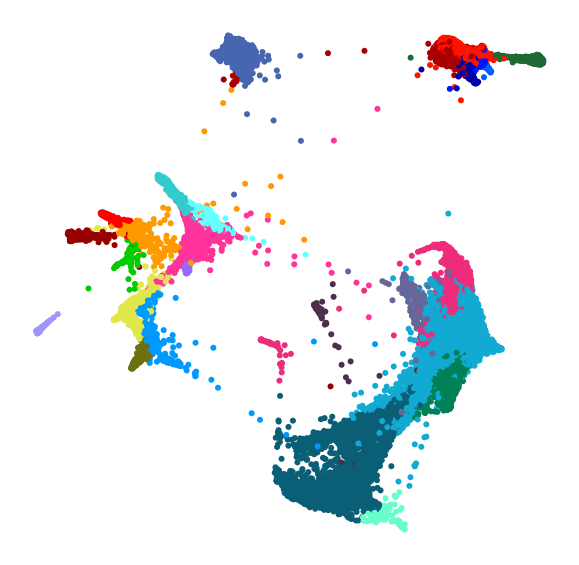

In [17]:
x = xy.iloc[:,0].values
y = -xy.iloc[:,1].values #flipped for some reason...

colors = [cdict[i] for i in adata.obs['*population'][cmask]]

fig = plt.figure(figsize=(10,10))
a = fig.add_subplot(1,1,1,frameon=False)
a.scatter(x,y,color=colors,lw=0)

a.set_xticks([])
a.set_yticks([])

## Normalize total counts to 10k

In [18]:
sc.pp.normalize_per_cell(adata,counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


## Let's plot the expression of a chosen gene

In [19]:
gene = 'Siglecf'

# boolean mask for selecting the gene
gmask = adata.var_names == gene
print(gmask.sum(),len(gmask))

# select vector with gene expression
e = adata.X[cmask,:][:,gmask].todense()
e = np.array(e).T[0]
e

1 40930


array([0.     , 0.     , 2.15378, ..., 0.     , 0.     , 0.     ],
      dtype=float32)

In [20]:
# "startfig" - a convenience (convenient to me at least) for starting a figure
help(rz.startfig)

Help on function startfig in module rz_functions:

startfig(w=4, h=2, rows=1, columns=1, wrs=None, hrs=None, frameon=True, return_first_ax=True)
    for initiating figures, w and h in centimeters
    example of use:
    a,fig,gs = startfig(w=10,h=2.2,rows=1,columns=3,wr=[4,50,1],hrs=None,frameon=True)
    hrs - height ratios
    wrs - width ratios
    frameon - whether first axes with frame
    
    returns:
    if return_first_ax=True
    a,fig,gs
    else
    fig,gs



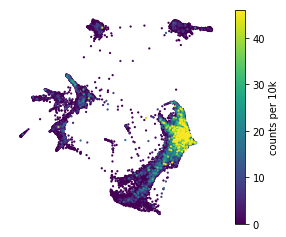

In [21]:
a,fig,gs = rz.startfig(12,10,frameon=False)
a.set_xticks([])
a.set_yticks([])

# I want to plot the highest expression on top
order = np.argsort(e)

# saturate color at 99.5th percentile
toppct = 99.5
vmax = np.percentile(e,toppct)

scat = a.scatter(x[order],y[order],c=e[order],lw=0,s=5,vmax=vmax)

cbar = fig.colorbar(scat)
cbar.set_label('counts per 10k')

### Get average expression per cluster

In [22]:
centroids = rz.centroids('*population',adata[cmask])

In [23]:
centroids

index,0610005C13Rik,0610006L08Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012D04Rik,0610012G03Rik,...,n-R5s90,n-R5s92,n-R5s93,n-R5s94,n-R5s95,n-R5s96,n-R5s97,n-R5s98,n-TSaga9,n-TStga1
B cells,0.082117,0.006262,0.063334,0.003547,0.039044,0.093478,0.050783,0.062383,0.003466,0.363520,...,0.000000,0.001537,0.000000,0.000000,0.000000,0.005117,0.0,0.000000,0.0,0.0
NK cells,0.059315,0.015670,0.130488,0.014858,0.075126,0.084109,0.110798,0.122143,0.034172,0.343265,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.016782,0.0,0.000000,0.0,0.0
N4,0.045441,0.005721,0.202574,0.011157,0.051454,0.068402,0.038682,0.075532,0.005633,0.645562,...,0.000000,0.000000,0.000547,0.002353,0.000000,0.000591,0.0,0.000000,0.0,0.0
Mac1,0.034936,0.002599,0.117664,0.001284,0.044470,0.068122,0.149265,0.021886,0.003990,1.372293,...,0.000000,0.001211,0.000000,0.000000,0.000000,0.000000,0.0,0.001101,0.0,0.0
Mono1,0.038702,0.000000,0.107204,0.006311,0.075911,0.058344,0.182277,0.036115,0.002321,0.836361,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
N1,0.090826,0.011131,0.086271,0.016165,0.070782,0.011429,0.025642,0.036211,0.004481,0.160843,...,0.000623,0.000000,0.000000,0.000000,0.000299,0.000975,0.0,0.000000,0.0,0.0
T_Cd8,0.027267,0.003820,0.077562,0.008601,0.030414,0.031349,0.097166,0.043895,0.000000,0.555654,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
Mono3,0.077316,0.008261,0.114198,0.014265,0.041037,0.042474,0.059186,0.037560,0.000000,0.569948,...,0.005733,0.005666,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
Mac2,0.022959,0.000000,0.262558,0.000000,0.083481,0.040428,0.257171,0.007482,0.000000,1.772929,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
N5,0.084343,0.000000,0.282875,0.029189,0.014282,0.054979,0.081810,0.102429,0.000000,1.004440,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0


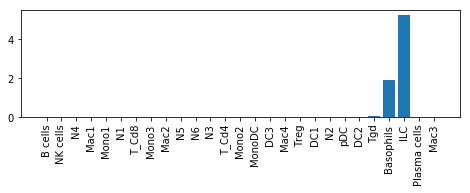

In [24]:
# show why I called one of the T cells subsets "Calca positive" (ILCs)
h = centroids['Calca']
x = np.arange(len(h))

a,fig,gs=rz.startfig(20,5)

a.bar(x,h)

a.set_xticks(x)
a.set_xticklabels(h.index,rotation=90);